In [1]:
# 这里我们只迭代更新映射层(全连接层)和语义属性

In [2]:
import sys
sys.path.append('..')

In [3]:
from py_file.M_attri import Att
from py_file.Get_Data import DATA
from py_file.data_set import MyDataSet
from torch.utils.data import DataLoader,Dataset,random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
import os
import math

In [4]:
trans = transforms.Resize(224)  # ResNet模型适合的图片大小为224x244
# 输入的张量需要带着批次维度和通道维度

In [5]:
# 定义训练的设备
if torch.cuda.is_available():
    device = torch.device('cuda:0') # 只有一张显卡的话，'cuda'和'cuda:0'是一样的
else:
    device = torch.device('cpu')
print(f'使用的设备为：{device}')

使用的设备为：cuda:0


# 加载数据

In [6]:
attri = Att()
attri.compute_mul_defect_att()

train_data_path = '/mnt/workspace/DATA/train_WM.npz'
train_data = np.load(train_data_path)

pseudo_two_data_path = 'data_fake_label/two_fake_label_WM.npz' 
pseudo_two_data = np.load(pseudo_two_data_path)

pseudo_three_data_path = 'data_fake_label/three_fake_label_WM.npz' 
pseudo_three_data = np.load(pseudo_three_data_path)

val_data_path = '/mnt/workspace/DATA/val_WM.npz'
val_data = np.load(val_data_path)

test_data_path = '/mnt/workspace/DATA/test_WM.npz'
test_data = np.load(test_data_path)

att_dimen = len(attri.att_name)

In [7]:
# 把标签转换为对应的属性向量
train_label = train_data['label_name']
pseudo_two_label = pseudo_two_data['label_name']
pseudo_three_label = pseudo_three_data['label_name']
val_label = val_data['label_name']
test_label = test_data['label_name']

train_att_vector = []
pseudo_two_att_vector = []
pseudo_three_att_vector = []
val_att_vector = []
test_att_vector = []

for l in train_data['label_name']:
    train_att_vector.append(attri.total_defect_att[l])
for l in pseudo_two_data['label_name']:
    pseudo_two_att_vector.append(attri.total_defect_att[l])
for l in pseudo_three_data['label_name']:
    pseudo_three_att_vector.append(attri.total_defect_att[l])
for l in val_data['label_name']:
    val_att_vector.append(attri.total_defect_att[l])
for l in test_data['label_name']:
    test_att_vector.append(attri.total_defect_att[l])

train_att_vector = np.array(train_att_vector)  # 因为np.array没有append方法，所以先使用list通过append添加元素，然后再将list转换为np.array
pseudo_two_att_vector = np.array(pseudo_two_att_vector)
pseudo_three_att_vector = np.array(pseudo_three_att_vector)
val_att_vector = np.array(val_att_vector)
test_att_vector = np.array(test_att_vector)

In [8]:
train_wm = train_data['denoise_wm']
train_wm_tensor = torch.reshape(torch.tensor(train_wm, dtype=torch.float32),(len(train_wm),1,52,52))
train_att_tensor = torch.tensor(train_att_vector, dtype=torch.float32)
print(train_wm_tensor.shape, train_att_tensor.shape)

pseudo_two_wm = pseudo_two_data['denoise_wm']
pseudo_two_wm_tensor = torch.reshape(torch.tensor(pseudo_two_wm, dtype=torch.float32),(len(pseudo_two_wm),1,52,52))
pseudo_two_att_tensor = torch.tensor(pseudo_two_att_vector, dtype=torch.float32)
print(pseudo_two_wm_tensor.shape, pseudo_two_att_tensor.shape)

pseudo_three_wm = pseudo_three_data['denoise_wm']
pseudo_three_wm_tensor = torch.reshape(torch.tensor(pseudo_three_wm, dtype=torch.float32),(len(pseudo_three_wm),1,52,52))
pseudo_three_att_tensor = torch.tensor(pseudo_three_att_vector, dtype=torch.float32)
print(pseudo_three_wm_tensor.shape, pseudo_three_att_tensor.shape)

val_wm = val_data['denoise_wm']
val_wm_tensor = torch.reshape(torch.tensor(val_wm, dtype=torch.float32),(len(val_wm),1,52,52))
val_att_tensor = torch.tensor(val_att_vector, dtype=torch.float32)
print(val_wm_tensor.shape, val_att_tensor.shape)

test_wm = test_data['denoise_wm']
test_wm_tensor = torch.reshape(torch.tensor(test_wm, dtype=torch.float32),(len(test_wm),1,52,52))
test_att_tensor = torch.tensor(test_att_vector, dtype=torch.float32)
print(test_wm_tensor.shape, test_att_tensor.shape)

torch.Size([25910, 1, 52, 52]) torch.Size([25910, 20])
torch.Size([2593, 1, 52, 52]) torch.Size([2593, 20])
torch.Size([4130, 1, 52, 52]) torch.Size([4130, 20])
torch.Size([3700, 1, 52, 52]) torch.Size([3700, 20])
torch.Size([7405, 1, 52, 52]) torch.Size([7405, 20])


In [9]:
train_wm_tensor = trans(train_wm_tensor)  # 修改图片大小，以适应网络输入
pseudo_two_wm_tensor = trans(pseudo_two_wm_tensor)
pseudo_three_wm_tensor = trans(pseudo_three_wm_tensor)
val_wm_tensor = trans(val_wm_tensor)
test_wm_tensor = trans(test_wm_tensor)
print(train_wm_tensor.shape, train_att_tensor.shape)
print(pseudo_two_wm_tensor.shape, pseudo_two_att_tensor.shape)
print(pseudo_three_wm_tensor.shape, pseudo_three_att_tensor.shape)
print(val_wm_tensor.shape, val_att_tensor.shape)
print(test_wm_tensor.shape, test_att_tensor.shape)

torch.Size([25910, 1, 224, 224]) torch.Size([25910, 20])
torch.Size([2593, 1, 224, 224]) torch.Size([2593, 20])
torch.Size([4130, 1, 224, 224]) torch.Size([4130, 20])
torch.Size([3700, 1, 224, 224]) torch.Size([3700, 20])
torch.Size([7405, 1, 224, 224]) torch.Size([7405, 20])


In [10]:
# 转换为列表的形式，方便后续拼接
pseudo_two_wm = list(pseudo_two_wm_tensor)
pseudo_two_label = list(pseudo_two_label)
pseudo_two_att = list(pseudo_two_att_tensor)
print(len(pseudo_two_wm),len(pseudo_two_att))
print(pseudo_two_wm[10].shape,pseudo_two_att[10].shape)

pseudo_three_wm = list(pseudo_three_wm_tensor)
pseudo_three_label = list(pseudo_three_label)
pseudo_three_att = list(pseudo_three_att_tensor)
print(len(pseudo_three_wm),len(pseudo_three_att))
print(pseudo_three_wm[10].shape, pseudo_three_att[10].shape)

2593 2593
torch.Size([1, 224, 224]) torch.Size([20])
4130 4130
torch.Size([1, 224, 224]) torch.Size([20])


In [11]:
del pseudo_two_wm_tensor, pseudo_two_att_tensor, pseudo_three_wm_tensor, pseudo_three_att_tensor

In [12]:
train_label_oh = train_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

train_single_wm = []  # 先定义列表，然后转换为tensor
train_single_label = []
train_single_att = []

train_two_wm = []
train_two_label = []
train_two_att = []

train_three_wm = []
train_three_label = []
train_three_att = []

train_four_wm = []
train_four_label = []
train_four_att = []
for i in range(len(train_label_oh)):
    if train_label_oh[i].sum() <= 1:
        train_single_wm.append(np.array(train_wm_tensor[i]))
        train_single_label.append(train_label[i])
        train_single_att.append(np.array(train_att_tensor[i]))
    elif train_label_oh[i].sum() == 2:
        train_two_wm.append(np.array(train_wm_tensor[i]))
        train_two_label.append(train_label[i])
        train_two_att.append(np.array(train_att_tensor[i]))
    elif train_label_oh[i].sum() == 3:
        train_three_wm.append(np.array(train_wm_tensor[i]))
        train_three_label.append(train_label[i])
        train_three_att.append(np.array(train_att_tensor[i]))
    elif train_label_oh[i].sum() == 4:
        train_four_wm.append(np.array(train_wm_tensor[i]))
        train_four_label.append(train_label[i])
        train_four_att.append(np.array(train_att_tensor[i]))

del train_data,train_wm_tensor,train_att_tensor

In [13]:
val_label_oh = val_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

val_single_wm = []  # 先定义列表，然后转换为tensor
val_single_label = []
val_single_att = []

val_two_wm = []
val_two_label = []
val_two_att = []

val_three_wm = []
val_three_label = []
val_three_att = []

val_four_wm = []
val_four_label = []
val_four_att = []

for i in range(len(val_label_oh)):
    if val_label_oh[i].sum() <= 1:
        val_single_wm.append(np.array(val_wm_tensor[i]))
        val_single_label.append(val_label[i])
        val_single_att.append(np.array(val_att_tensor[i]))
    elif val_label_oh[i].sum() == 2:
        val_two_wm.append(np.array(val_wm_tensor[i]))
        val_two_label.append(val_label[i])
        val_two_att.append(np.array(val_att_tensor[i]))
    elif val_label_oh[i].sum() == 3:
        val_three_wm.append(np.array(val_wm_tensor[i]))
        val_three_label.append(val_label[i])
        val_three_att.append(np.array(val_att_tensor[i]))
    elif val_label_oh[i].sum() == 4:
        val_four_wm.append(np.array(val_wm_tensor[i]))
        val_four_label.append(val_label[i])
        val_four_att.append(np.array(val_att_tensor[i]))

del val_data,val_wm_tensor,val_att_tensor

In [14]:
test_label_oh = test_data['label_one_hot']
# 通过one_hot标签给数据分为单缺陷、双缺陷、三缺陷以及四缺陷

test_single_wm = []  # 先定义列表，然后转换为tensor
test_single_label = []
test_single_att = []

test_two_wm = []
test_two_label = []
test_two_att = []

test_three_wm = []
test_three_label = []
test_three_att = []

test_four_wm = []
test_four_label = []
test_four_att = []
for i in range(len(test_label_oh)):
    if test_label_oh[i].sum() <= 1:
        test_single_wm.append(np.array(test_wm_tensor[i]))
        test_single_label.append(test_label[i])
        test_single_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 2:
        test_two_wm.append(np.array(test_wm_tensor[i]))
        test_two_label.append(test_label[i])
        test_two_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 3:
        test_three_wm.append(np.array(test_wm_tensor[i]))
        test_three_label.append(test_label[i])
        test_three_att.append(np.array(test_att_tensor[i]))
    elif test_label_oh[i].sum() == 4:
        test_four_wm.append(np.array(test_wm_tensor[i]))
        test_four_label.append(test_label[i])
        test_four_att.append(np.array(test_att_tensor[i]))

del test_data,test_wm_tensor,test_att_tensor

In [15]:
train_wm = train_single_wm + pseudo_two_wm + pseudo_three_wm
train_label = train_single_label + pseudo_two_label + pseudo_three_label
train_att = train_single_att + pseudo_two_att + pseudo_three_att

train_wm_tensor = torch.tensor(np.array(train_wm), dtype=torch.float32)
train_att_tensor = torch.tensor(np.array(train_att), dtype=torch.float32)
# 由于更新语义需要的样本较多，所以我们使用训练集的样本来更新语义
train_single_wm_tensor = torch.tensor(np.array(train_single_wm), dtype=torch.float32)
# train_two_wm_tensor = torch.tensor(np.array(train_two_wm), dtype=torch.float32)
# train_three_wm_tensor = torch.tensor(np.array(train_three_wm), dtype=torch.float32)
# train_four_wm_tensor = torch.tensor(np.array(train_four_wm), dtype=torch.float32)
train_mul_wm = train_two_wm + train_three_wm + train_four_wm
train_mul_wm_tensor = torch.tensor(np.array(train_mul_wm), dtype=torch.float32)

val_wm = val_two_wm + val_three_wm + val_four_wm
val_label = val_two_label + val_three_label + val_four_label
val_att = val_two_att + val_three_att + val_four_att

val_wm_tensor = torch.tensor(np.array(val_wm), dtype=torch.float32)
val_att_tensor = torch.tensor(np.array(val_att), dtype=torch.float32)


test_wm = test_two_wm + test_three_wm + test_four_wm
test_label = test_two_label + test_three_label + test_four_label
test_att = test_two_att + test_three_att + test_four_att

test_wm_tensor = torch.tensor(np.array(test_wm), dtype=torch.float32)
test_att_tensor = torch.tensor(np.array(test_att), dtype=torch.float32)

In [16]:
train_size = len(train_wm_tensor)
val_size = len(val_wm_tensor)
test_size = len(test_wm_tensor)
# 因为我们每次训练后，需要更新训练样本的语义，所以我们的dataset和dataloader在训练的for循环里定义

In [17]:
single_defect_att = attri.single_defect_att
two_defect_att = attri.two_defect_att
three_defect_att = attri.three_defect_att
four_defect_att = attri.four_defect_att
mul_defect_att = attri.mul_defect_att

# 定义模型

In [18]:
# 我们使用已经在可见类上训练，建立了一定的视觉到语义映射关系的模型
model = torch.load('model_saved_pseudo/train_single_two_three.pth')
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
for param in model.parameters():
    param.requires_grad = False

# 如果需要微调后面的层，可以选择性地解冻
for param in model.fc.parameters():  # 解冻全连接层和sigmoid
    param.requires_grad = True

for param in model.sigmoid.parameters():
    param.requires_grad = True

# 定义模型训练时需要的函数

In [20]:
from py_file.func_Test import Test_Func
# 需要的函数都已经集成在了Test_Func里
func = Test_Func()

In [21]:
# 我们以余弦相似度进行KNN
def cosine_similarity(v1, v2):  # 参数v1,v2是np.array,不能是tensor，可以用np.array()将tensor转换为array
    # 计算两个向量的点积
    dot_product = np.dot(v1, v2)
    # 计算两个向量的模
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    # 计算余弦相似度
    similarity = dot_product / (norm_v1 * norm_v2)
    return similarity


def knn(query_embedding, embeddings, k=5):
    similarities = []
    for embedding in embeddings:
        similarity = cosine_similarity(query_embedding, embedding)
        similarities.append(similarity)
    sorted_indices = np.argsort(similarities)[::-1]  # [::-1] 表示逆序，因为np.argsort()默认是升序

    k_embeddings = []
    for i in range(k):
        k_embeddings.append(embeddings[sorted_indices[i]])
    k_embeddings = np.array(k_embeddings)  # 转换为np.array
    return k_embeddings  # 返回了与query最相似的k个embedding


def update_semantic(model, old_att_dict, inputs, k=5):
    outputs = []
    for wm in inputs:
        wm = wm.to(device)
        wm = wm.reshape((1,1,224,224))
        out = model(wm)
        out = out.detach().cpu().numpy()
        out = out.reshape((-1,))  # out是一个一维向量，需要将其转换为一维向量
        outputs.append(out)
    new_att_dict = {}
    for label,att in old_att_dict.items():
        k_embeddings = knn(att, outputs, k=k)
        new_att = np.mean(k_embeddings, axis=0)
        new_att_dict[label] = torch.tensor(new_att, dtype=torch.float32)

    return new_att_dict

# 开始训练

In [22]:
model = model.to(device)
loss_func = nn.MSELoss().to(device=device)
learning_rate = 1e-2  # 0.01
optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [23]:
epochs = 20  # 训练迭代的次数，一个epoch把训练集过一遍

In [24]:
import time
import pickle
best_acc = 0
No = 0
for epoch in range(epochs):
    # 每轮训练前，我们更新缺陷类型属性
    single_defect_att = update_semantic(model, single_defect_att, train_single_wm_tensor, 50)  # 获得新的缺陷属性字典
    mul_defect_att = update_semantic(model, mul_defect_att, train_mul_wm_tensor, 50)
    total_defect_att = {**single_defect_att, **mul_defect_att}
    for i in range(len(train_label)):
        train_att_tensor[i] = total_defect_att[train_label[i]]

    # 定义dataset和dataloader
    train_dataset = MyDataSet(train_wm_tensor,train_att_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    print(f'————第{epoch+1}轮训练开始————')

    model.train()   # 开始训练
    total_train_loss = 0
    start_time = time.time()
    for imgs,labels in train_loader:

        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = model(imgs)
        # print(outputs)
        loss = loss_func(outputs, labels)
        total_train_loss = total_train_loss + loss.item()

        # 优化器优化模型
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    end_time = time.time()
    print(f'训练时间为：{end_time-start_time}, 总Loss:{total_train_loss}')  # loss是一个tensor数据类型，loss.item()是一个浮点数数据类型
    print(f'****第{epoch+1}轮训练结束****')


    # 验证步骤开始
    model.eval()   # 开始验证

    for i in range(len(val_label)):
        val_att_tensor[i] = mul_defect_att[val_label[i]] 

    # 定义dataset和dataloader
    val_dataset = MyDataSet(val_wm_tensor, val_att_tensor)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    total_val_loss = 0
    # with的作用是可以确保代码块执行完毕后，资源被正确释放，也就是使用with，在执行完外码块之后，它会自动地关闭所打开的内容
    # 例如关闭文件、释放线程锁等
    with torch.no_grad():   # 这里要进行验证，不需要修改参数，所以不计算梯度
        for imgs,labels in val_loader:  
            
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            outputs = model(imgs)
            # 计算损失
            loss = loss_func(outputs,labels)
            total_val_loss = total_val_loss+loss.item()  # loss是一个tensor数据类型，loss.item()是一个浮点数数据类型

    # 计算准确率
    acc = func.get_acc(model, val_loader, mul_defect_att, val_size, 'cos')
    print(f'第{epoch+1}轮训练后,整体验证集上的Loss:{total_val_loss}')
    print(f'第{epoch+1}轮训练后,整体验证集上的Accuracy:{acc}')
    if acc > best_acc:
        best_acc = acc
        No = epoch+1
        # 保存最好的模型和语义属性
        torch.save(obj=model,f='model_saved_pseudo/single_two_three_four_updated.pth')

        with open('updated_semantic_1_2_3_4/updated_single_dict.pkl', 'wb') as file:
            pickle.dump(single_defect_att, file)  # pickle 模块的dump函数，将数据写入文件，pickle可以写入任何类型的数据
        with open('updated_semantic_1_2_3_4/updated_mul_dict.pkl', 'wb') as file:
            pickle.dump(mul_defect_att, file)
        

print(f'训练结束，第{No}轮的模型在验证集上准确率最高，为{best_acc}')


————第1轮训练开始————
训练时间为：4.169867038726807, 总Loss:1.3380413327831775
****第1轮训练结束****
第1轮训练后,整体验证集上的Loss:1.9632880472927354
第1轮训练后,整体验证集上的Accuracy:0.6227586206896552
————第2轮训练开始————
训练时间为：4.091558218002319, 总Loss:1.2094852873124182
****第2轮训练结束****
第2轮训练后,整体验证集上的Loss:1.691564348700922
第2轮训练后,整体验证集上的Accuracy:0.6506896551724138
————第3轮训练开始————
训练时间为：4.035709619522095, 总Loss:1.2078350218944252
****第3轮训练结束****
第3轮训练后,整体验证集上的Loss:2.0026150842604693
第3轮训练后,整体验证集上的Accuracy:0.6210344827586207
————第4轮训练开始————
训练时间为：3.982710838317871, 总Loss:1.1118560368195176
****第4轮训练结束****
第4轮训练后,整体验证集上的Loss:1.7108297305530868
第4轮训练后,整体验证集上的Accuracy:0.6479310344827586
————第5轮训练开始————
训练时间为：3.9957900047302246, 总Loss:1.1454206458292902
****第5轮训练结束****
第5轮训练后,整体验证集上的Loss:1.8928421026212163
第5轮训练后,整体验证集上的Accuracy:0.6331034482758621
————第6轮训练开始————
训练时间为：4.092657089233398, 总Loss:1.1596484605688602
****第6轮训练结束****
第6轮训练后,整体验证集上的Loss:1.8494657672126777
第6轮训练后,整体验证集上的Accuracy:0.6420689655172414
————第7轮训练开始————
训练时间为：4.0201

In [25]:
del train_dataset,train_loader,val_dataset,val_loader

In [26]:
del train_wm_tensor,train_att_tensor,val_wm_tensor,val_att_tensor

# 开始测试

In [27]:
import pickle
model = torch.load('model_saved_pseudo/train_single_two_three.pth')
model.eval()

with open('updated_semantic_1_2_3_4/updated_single_dict.pkl', 'rb') as file:
    single_defect_att = pickle.load(file)
with open('updated_semantic_1_2_3_4/updated_mul_dict.pkl', 'rb') as file:
    mul_defect_att = pickle.load(file)


In [28]:
for i in range(len(test_label)):
    test_att_tensor[i] = mul_defect_att[test_label[i]]

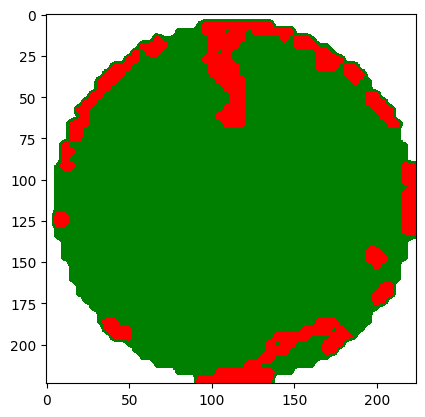

预测的属性向量tensor([ 2.6125e-01,  2.7017e-01,  4.9738e-01,  6.0603e-01,  1.1526e+00,
         7.0469e-01,  8.2194e-01,  6.1746e-01,  8.8902e-01, -1.0923e-02,
        -9.4029e-04, -5.3838e-03,  6.8032e-01,  9.5547e-01,  5.9945e-01,
         7.0770e-01,  8.2175e-01,  6.1747e-01,  5.4563e-01,  6.4856e-01],
       device='cuda:0')
真实的属性向量tensor([ 0.2693,  0.4057,  0.6978,  0.7911,  1.0909,  0.8594,  0.8367,  0.7677,
         0.9464, -0.0147, -0.0027, -0.0093,  0.5920,  0.9872,  0.4590,  0.8578,
         0.8368,  0.7679,  0.6062,  0.7894])
真实标签为：ER+L+S
欧式距离计算的标签为：ER+L+S
余弦相似度计算的标签为：ER+L+S


In [30]:
func.show_result(model, test_wm_tensor, test_att_tensor, mul_defect_att)

## 测试集里的

In [31]:
test_dataset = MyDataSet(test_wm_tensor, test_att_tensor)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [32]:
print(func.get_acc(model, test_loader, mul_defect_att, len(test_dataset), 'cos'))

0.7008620689655173


# 训练集里的

In [33]:
train_mul_label = train_two_label + train_three_label + train_four_label

train_mul_att = train_two_att + train_three_att + train_four_att
train_mul_att_tensor = torch.tensor(train_mul_att, dtype=torch.float32)
for i in range(len(train_mul_label)):
    train_mul_att_tensor[i] = mul_defect_att[train_mul_label[i]]

/tmp/ipykernel_21090/311944114.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  train_mul_att_tensor = torch.tensor(train_mul_att, dtype=torch.float32)


In [34]:
train_mul_dataset = MyDataSet(train_mul_wm_tensor, train_mul_att_tensor)

train_mul_loader = DataLoader(train_mul_dataset, batch_size=32, shuffle=False)

In [35]:
print(func.get_acc(model, train_mul_loader, mul_defect_att, len(train_mul_dataset), 'cos'))

0.6897536945812808
